In [ ]:

pip install pandas requests matplotlib


In [ ]:
import pandas as pd
import sqlite3
from pyowm.owm import OWM
import matplotlib.pyplot as plt

# Step 0: Setup
api_key = "3d43f524a8790fdea24f35910495e5d8"
owm = OWM(api_key)
mgr = owm.weather_manager()

66.63
6.213727366498068
3.44
moderate rain
2025-05-11T19:38:57
2025-05-12T09:36:20
              city  max_temp  visibility  wind_speed                  status  \
0         Tokyo,JP     66.63    6.213727        3.44           moderate rain   
1         Paris,FR     73.58    6.213727       12.66           broken clouds   
2       Nairobi,KE     62.47    4.349609        9.22  thunderstorm with rain   
3  Buenos Aires,AR     67.89    6.213727       11.01               clear sky   
4        Sydney,AU     62.71    6.213727        5.75              light rain   

               sunrise               sunset  
0  2025-05-11T19:38:57  2025-05-12T09:36:20  
1  2025-05-11T04:14:22  2025-05-11T19:19:40  
2  2025-05-11T03:27:19  2025-05-11T15:30:59  
3  2025-05-11T10:37:19  2025-05-11T21:02:31  
4  2025-05-11T20:37:53  2025-05-12T07:05:16  
           weather_status  avg_wind_speed  max_temp
0           broken clouds        14.38500     76.08
1               clear sky         8.23625    102.96
2   

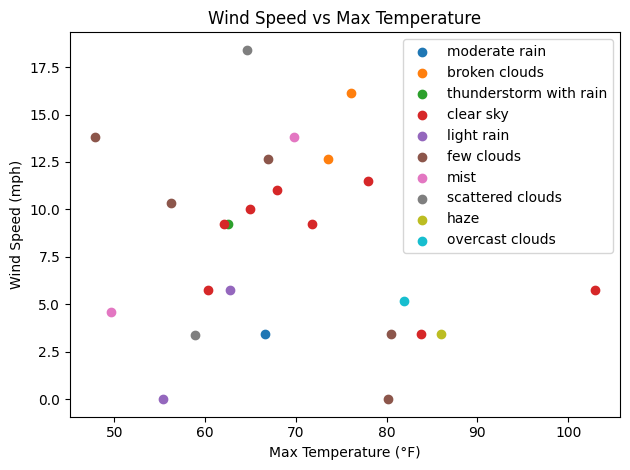

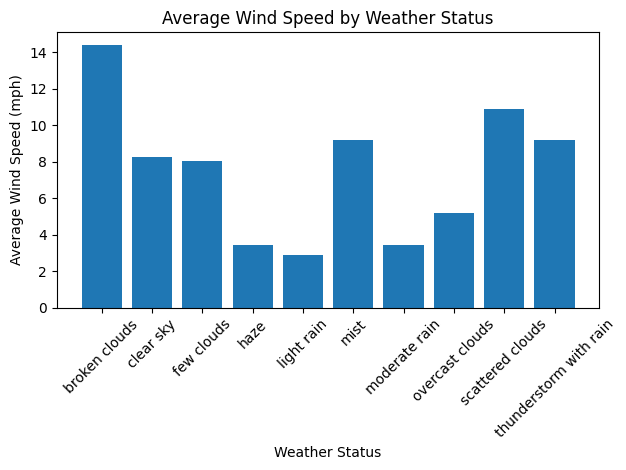

In [ ]:
import pandas as pd
import sqlite3
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# API setup
api_key     = "3d43f524a8790fdea24f35910495e5d8"
weather_url = "https://api.openweathermap.org/data/2.5/weather"

# Step 2: Test API call for Tokyo using city name query
response = requests.get(
    weather_url,
    params={
        "q":     "Tokyo,JP",
        "appid": api_key,
        "units": "imperial"
    }
)
response.raise_for_status()
data = response.json()

print(data["main"]["temp_max"])                # max temp (°F)
print(data.get("visibility", 0) / 1609.34)     # visibility (miles)
print(data["wind"]["speed"])                   # wind speed (mph)
print(data["weather"][0]["description"])       # status
print(datetime.fromtimestamp(data["sys"]["sunrise"]).isoformat())
print(datetime.fromtimestamp(data["sys"]["sunset"]).isoformat())

# Step 3: Extraction function using city name query

def extract_weather_data(city):
    r = requests.get(
        weather_url,
        params={
            "q":     city,
            "appid": api_key,
            "units": "imperial"
        }
    )
    r.raise_for_status()
    d = r.json()
    return {
        "city":       city,
        "max_temp":   d["main"]["temp_max"],
        "visibility": d.get("visibility", 0) / 1609.34,
        "wind_speed": d["wind"]["speed"],
        "status":     d["weather"][0]["description"],
        "sunrise":    datetime.fromtimestamp(d["sys"]["sunrise"]).isoformat(),
        "sunset":     datetime.fromtimestamp(d["sys"]["sunset"]).isoformat()
    }

# Step 4: Apply to list of 25 cities
cities = [
    "Tokyo,JP", "Paris,FR", "Nairobi,KE", "Buenos Aires,AR", "Sydney,AU",
    "New York,US", "Los Angeles,US", "Toronto,CA", "Mexico City,MX", "Rio de Janeiro,BR",
    "Cape Town,ZA", "Cairo,EG", "Beijing,CN", "Mumbai,IN", "Seoul,KR",
    "London,GB", "Berlin,DE", "Rome,IT", "Madrid,ES", "Lisbon,PT",
    "Bangkok,TH", "Jakarta,ID", "Kuala Lumpur,MY", "Istanbul,TR", "Reykjavik,IS"
]
records = [extract_weather_data(city) for city in cities]
current_weather = pd.DataFrame(records)
print(current_weather.head())

# Step 5: Store weather data in SQLite
conn = sqlite3.connect("weather_data.db")
current_weather.to_sql("city_weather", conn, if_exists="replace", index=False)

# Aggregate by weather status
agg_weather_status = pd.read_sql_query(
    """
    SELECT status        AS weather_status,
           AVG(wind_speed) AS avg_wind_speed,
           MAX(max_temp)   AS max_temp
    FROM city_weather
    GROUP BY status
    """,
    conn
)
print(agg_weather_status)

# Top 5 hottest cities
hottest_cities = pd.read_sql_query(
    """
    SELECT *
    FROM city_weather
    ORDER BY max_temp DESC
    LIMIT 5
    """,
    conn
)
print(hottest_cities)

# Step 6: Visualizations
plt.figure()
for s in current_weather["status"].unique():
    subset = current_weather[current_weather["status"] == s]
    plt.scatter(subset["max_temp"], subset["wind_speed"], label=s)

plt.title("Wind Speed vs Max Temperature")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("Wind Speed (mph)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(
    agg_weather_status["weather_status"],
    agg_weather_status["avg_wind_speed"]
)
plt.title("Average Wind Speed by Weather Status")
plt.xlabel("Weather Status")
plt.ylabel("Average Wind Speed (mph)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




## Step 7: Summary

**Most favorable weather**  
Based on our current data, **Los Angeles, US** offers the most ideal and pleasant conditions:  
- Max temperature: 83.8 °F  
- Weather: clear sky  
- Wind speed: 3.4 mph  

**Patterns between max temperature and wind speed**  
- Extremely hot cities (e.g., Cairo at 102.96 °F) have moderate wind speeds (~5–6 mph).  
- Storm conditions (e.g., Nairobi’s thunderstorm at 62.5 °F) mean higher winds (>9 mph).  
- Overall, there isn’t a strict linear correlation. Wind strength varies more by weather status than by temperature alone.

**Patterns between average wind speed and weather status**  
- **Highest winds** occur with broken clouds (14.4 mph) and scattered clouds (10.9 mph).  
- **Lowest winds** occur during light rain (2.9 mph) and moderate rain (3.4 mph).  
- **Clear sky** days sit in the middle at around 8.2 mph.
